In [ ]:
!pip install selenium
!pip install networkx
!pip install matplotlib
!pip install nltk
!pip install tqdm
!pip install pandas
!pip install sklearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 11.8 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import pandas as pd
import re

from tqdm import tqdm

import pickle
import nltk
import networkx as nx
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize , word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def web_driver():
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(options=options)
    return driver

def get_element_text(driver, xpath):
    try:
        return WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.XPATH, xpath))
        ).text.strip()
    except Exception as e:
        print(f"Error finding element with XPath {xpath}: {e}")
        return ""

def extract_article_content(driver, article_url):
    driver.get(article_url)
    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, '//h1'))
    )
    title = get_element_text(driver, './/h1')

    # XPath untuk tanggal
    date = get_element_text(driver, './/p[@class="pt-20 date"]')

    # XPath untuk konten
    content_elements = driver.find_elements(By.XPATH, './/div[@class="news-text"]/p')
    content = " ".join(p.text for p in content_elements)

    # XPath untuk kategori
    kategori = get_element_text(driver, './/div[@class="breadcrumb-content"]/p')

    return {
        "Title": title,
        "Date": date,
        "Content": content,
        "Category": kategori  # Menyimpan kategori dalam hasil
    }

driver = web_driver()

# Meminta input dari pengguna untuk URL artikel
url_input = input("Masukkan URL artikel: ")

# Scraping data dari URL artikel yang diberikan oleh pengguna
article_data = extract_article_content(driver, url_input)

driver.quit()

# Simpan hasil scraping ke dalam DataFrame
data = pd.DataFrame([article_data])  # Mengonversi hasil ke dalam list untuk membuat DataFrame

Masukkan URL artikel: https://www.metrotvnews.com/play/bJECam3B-timnas-indonesia-kumpul-di-jakarta-pada-10-november


In [ ]:
# Fungsi untuk mengubah teks menjadi huruf kecil
def clean_lower(text):
    if isinstance(text, str):
        return text.lower()
    return text

data['lower case'] = data['Content'].apply(clean_lower)

# Fungsi untuk membersihkan tanda baca dan angka (menghapus koma)
def clean_punct(text):
    if isinstance(text, str):
        clean_patterns = re.compile(r'[0-9]|[/(){}\[\]\|@,;_]|[^a-z .]+')  # Koma dihilangkan dari pengecualian
        text = clean_patterns.sub(' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    return text

data['tanda baca'] = data['lower case'].apply(clean_punct)

# Fungsi untuk normalisasi spasi
def _normalize_whitespace(text):
    if isinstance(text, str):
        corrected = re.sub(r'\s+', ' ', text)
        return corrected.strip()
    return text

data['spasi'] = data['tanda baca'].apply(_normalize_whitespace)

# Tokenisasi
def tokenize_text(text):
    if isinstance(text, str):
        return word_tokenize(text)
    return text

data['token'] = data['spasi'].apply(tokenize_text)

# Pembersihan stopwords setelah tokenisasi
def clean_stopwords(tokens):
    if isinstance(tokens, list):
        stopword = set(stopwords.words('indonesian'))
        filtered_tokens = [word for word in tokens if word not in stopword]
        return filtered_tokens
    return tokens

data['stopwords'] = data['token'].apply(clean_stopwords)

# Gabungkan kembali token menjadi string
data['processed_text'] = data['stopwords'].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else '')

In [ ]:
prep_result = data['processed_text'].to_dict()
print(prep_result)

{0: 'sekjen persatuan sepak bola indonesia pssi yunus nusi mengungkap pemain timnas indonesia berkumpul november . menghadapi jepang november . insyaallah tanggal november anak anak gabung jakarta semoga sehat bugar persiapan pertandingan jepang tanggal yunus nusi tayangan metro siang metro tv selasa november . yunus persiapan diserahkan sepenuhnya pelatih shin tae yong sty . bertanggung melayani pemain akomodasi pesawat makanan kelengkapan pemain . arahan ketua anak anak pelatih ofisial layani maksimal erick thohir berharap lalai melayani anak anak perjuangan anak anak berat jepang . standny maksimal melayani timnas .'}


In [ ]:
kalimat_preprocessing = nltk.sent_tokenize(prep_result[0])
kalimat = nltk.sent_tokenize(data['Content'][0])

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_preprocessing = tfidf_vectorizer.fit_transform(kalimat_preprocessing)
terms = tfidf_vectorizer.get_feature_names_out()
tfidf_preprocessing = pd.DataFrame(data=tfidf_preprocessing.toarray(), columns=terms)
tfidf_preprocessing

,akomodasi,anak,arahan,berat,berharap,berkumpul,bertanggung,bola,bugar,diserahkan,...,standny,sty,tae,tanggal,tayangan,thohir,timnas,tv,yong,yunus
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.266558,0.000000,0.266558,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.221266,0.000000,0.000000,0.189131
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.324621,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.195535,0.000000,...,0.0000,0.000000,0.000000,0.391069,0.195535,0.000000,0.000000,0.195535,0.000000,0.138738
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.356201,...,0.0000,0.356201,0.356201,0.000000,0.000000,0.000000,0.000000,0.000000,0.356201,0.252735
4,0.347953,0.000000,0.000000,0.000000,0.000000,0.000000,0.347953,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.816692,0.163977,0.163977,0.163977,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0000,0.000000,0.000000,0.000000,0.000000,0.163977,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.5891,0.000000,0.000000,0.000000,0.000000,0.000000,0.489004,0.000000,0.000000,0.000000


In [ ]:
cossim_prep = cosine_similarity(tfidf_preprocessing, tfidf_preprocessing)

similarity_matrix = pd.DataFrame(cossim_prep,
								 index=range(len(kalimat_preprocessing)),
								 columns=range(len(kalimat_preprocessing)))

similarity_matrix

,0,1,2,3,4,5,6
0,1.000000,0.094727,0.114632,0.047800,0.127817,0.000000,0.108200
1,0.094727,1.000000,0.208462,0.000000,0.000000,0.058273,0.000000
2,0.114632,0.208462,1.000000,0.083055,0.000000,0.281257,0.000000
3,0.047800,0.000000,0.083055,1.000000,0.000000,0.040246,0.000000
4,0.127817,0.000000,0.000000,0.000000,1.000000,0.028724,0.103193
5,0.000000,0.058273,0.281257,0.040246,0.028724,1.000000,0.115192
6,0.108200,0.000000,0.000000,0.000000,0.103193,0.115192,1.000000


In [ ]:
import matplotlib.pyplot as plt


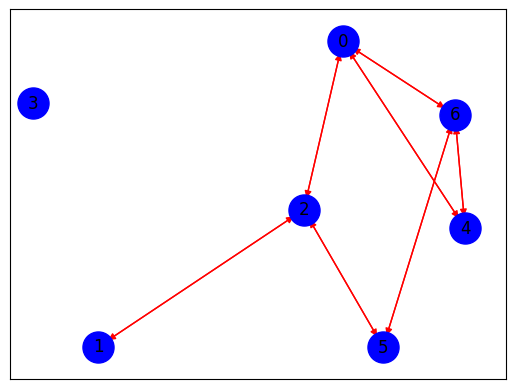

In [ ]:
G_preprocessing = nx.DiGraph()
for i in range(len(cossim_prep)):
    G_preprocessing.add_node(i)

for i in range(len(cossim_prep)):
    for j in range(len(cossim_prep)):
        similarity_preprocessing = cossim_prep[i][j]
        if similarity_preprocessing > 0.1 and i != j:
            G_preprocessing.add_edge(i, j)

pos = nx.spring_layout(G_preprocessing, k=2)
nx.draw_networkx_nodes(G_preprocessing, pos, node_size=500, node_color='b')
nx.draw_networkx_edges(G_preprocessing, pos, edge_color='red', arrows=True)
nx.draw_networkx_labels(G_preprocessing, pos)

plt.show()

In [ ]:
closeness_preprocessing = nx.closeness_centrality(G_preprocessing)

sorted_closeness_preprocessing = sorted(closeness_preprocessing.items(), key=lambda x: x[1], reverse=True)
print("Closeness Centrality:")
for node, closeness in sorted_closeness_preprocessing:
    print(f"Node {node}: {closeness:.4f}")

Closeness Centrality:
Node 0: 0.5952
Node 2: 0.5952
Node 5: 0.5208
Node 6: 0.5208
Node 4: 0.4630
Node 1: 0.3788
Node 3: 0.0000


In [ ]:
ringkasan_closeness_preprocessing = ""
print("Tiga Node Tertinggi Closeness Centrality Menggunakan Preprocessing:")
for node, closeness_preprocessing in sorted_closeness_preprocessing[:3]:
    top_sentence = kalimat[node]
    ringkasan_closeness_preprocessing += top_sentence + " "
    print(f"Node {node}: Closeness Centrality = {closeness_preprocessing:.4f}")
    print(f"Kalimat: {top_sentence}\n")

Tiga Node Tertinggi Closeness Centrality Menggunakan Preprocessing:
Node 0: Closeness Centrality = 0.5952
Kalimat: Sekjen Persatuan Sepak Bola Seluruh Indonesia (PSSI) Yunus Nusi mengungkap para pemain Timnas Indonesia mulai berkumpul pada 10 November 2024.

Node 2: Closeness Centrality = 0.5952
Kalimat: "Insyaallah tanggal 10 (November) anak-anak sudah gabung di sini Jakarta dan semoga mereka dalam keadaan sehat, bugar untuk persiapan pertandingan dengan Jepang di tanggal 15 nanti," kata Yunus Nusi dalam tayangan Metro Siang, Metro TV, Selasa, 5 November 2024.

Node 5: Closeness Centrality = 0.5208
Kalimat: "Arahan ketua umum, anak-anak dan pelatih ofisial ini kita layani secara maksimal dan tentu Pak Erick Thohir berharap bahwa jangan sampai kita lalai untuk melayani anak-anak ini karena perjuangan anak-anak ini begitu berat, apalagi dengan Jepang.



In [ ]:
# Membuat ringkasan sebagai satu paragraf
ringkasan_closeness_preprocessing = " ".join(kalimat[node] for node, _ in sorted_closeness_preprocessing[:3])

# Mencetak ringkasan sebagai satu paragraf
print("Ringkasan artikel dalam satu paragraf:")
print(ringkasan_closeness_preprocessing)

Ringkasan artikel dalam satu paragraf:
Sekjen Persatuan Sepak Bola Seluruh Indonesia (PSSI) Yunus Nusi mengungkap para pemain Timnas Indonesia mulai berkumpul pada 10 November 2024. "Insyaallah tanggal 10 (November) anak-anak sudah gabung di sini Jakarta dan semoga mereka dalam keadaan sehat, bugar untuk persiapan pertandingan dengan Jepang di tanggal 15 nanti," kata Yunus Nusi dalam tayangan Metro Siang, Metro TV, Selasa, 5 November 2024. "Arahan ketua umum, anak-anak dan pelatih ofisial ini kita layani secara maksimal dan tentu Pak Erick Thohir berharap bahwa jangan sampai kita lalai untuk melayani anak-anak ini karena perjuangan anak-anak ini begitu berat, apalagi dengan Jepang.
